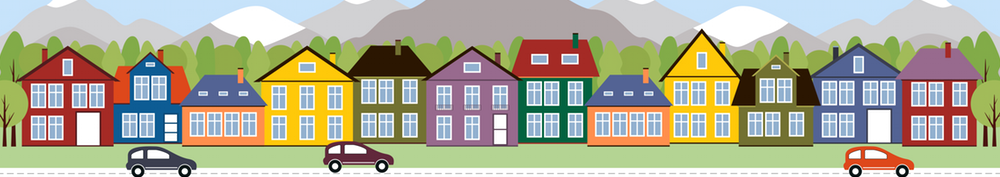



<h2 align="center">House Price Prediction</h2>

### Predicting the selling price of houses based on various features such as area, number of bedrooms, location, etc.

In [12]:
import sys
import subprocess

# Function to install required packages
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# List of required packages
required_packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'xgboost']

# Install required packages
for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        install(package)

# Now import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import pickle
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set style for plots
print("Available styles:", plt.style.available)
plt.style.use('default')  # Using 'default' style which should be always available

# Set up Seaborn defaults
sns.set_theme()  # This sets up Seaborn defaults

# Load the data
with pd.option_context('mode.use_inf_as_na', True):
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')

# Replace infinite values with NaN
train_data = train_data.replace([np.inf, -np.inf], np.nan)
test_data = test_data.replace([np.inf, -np.inf], np.nan)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Available styles: ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Train data shape: (1460, 81)
Test data shape: (1459, 80)


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


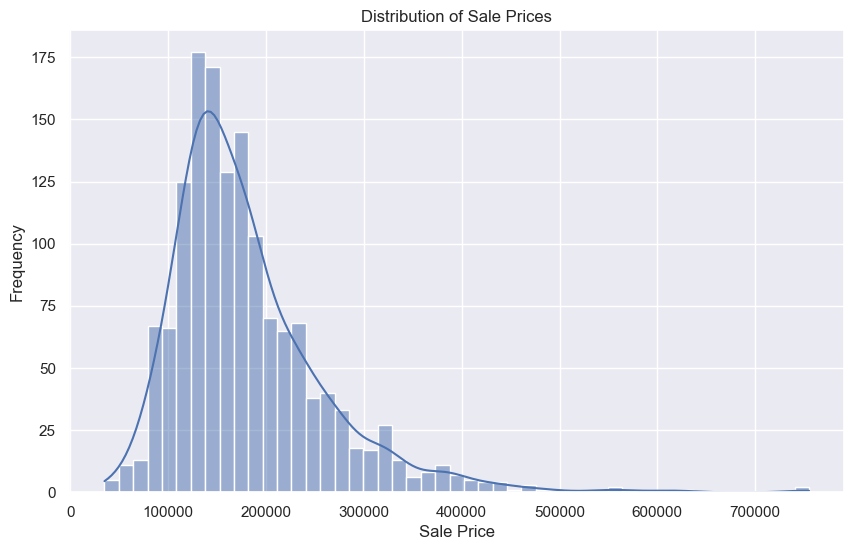

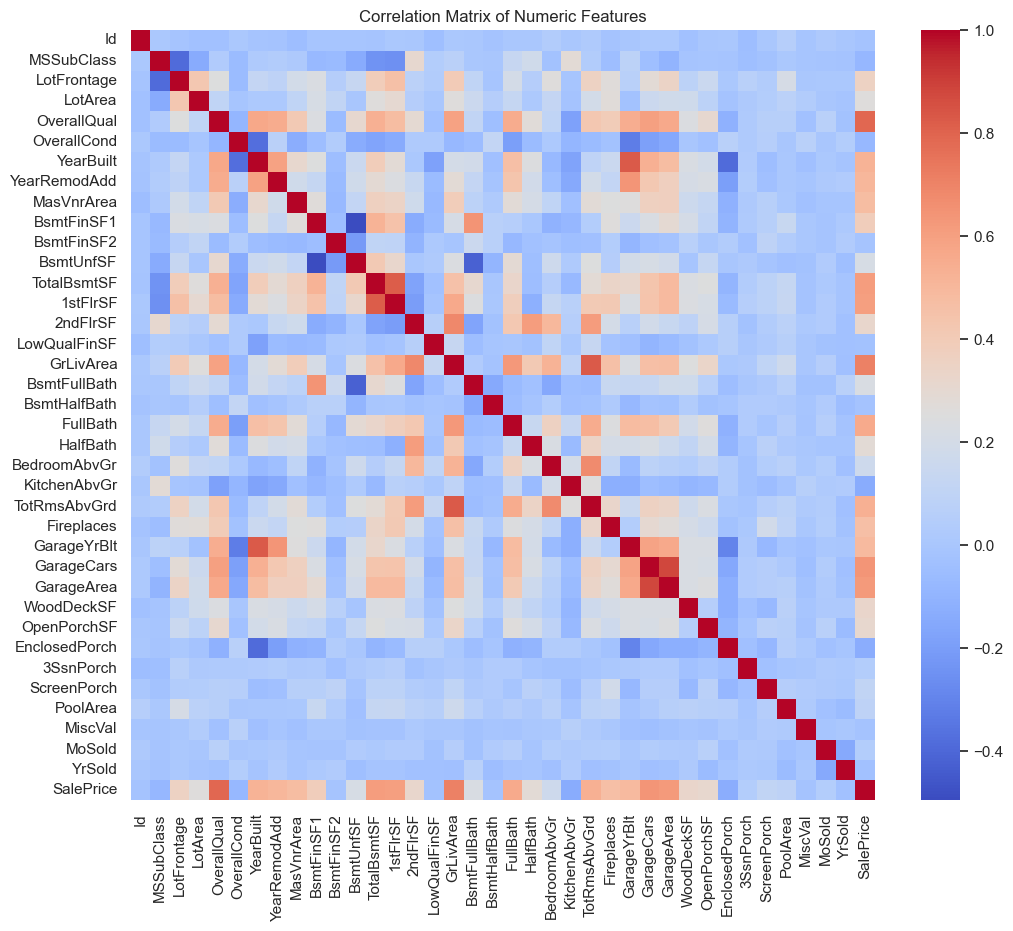

Top 10 features correlated with SalePrice:
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


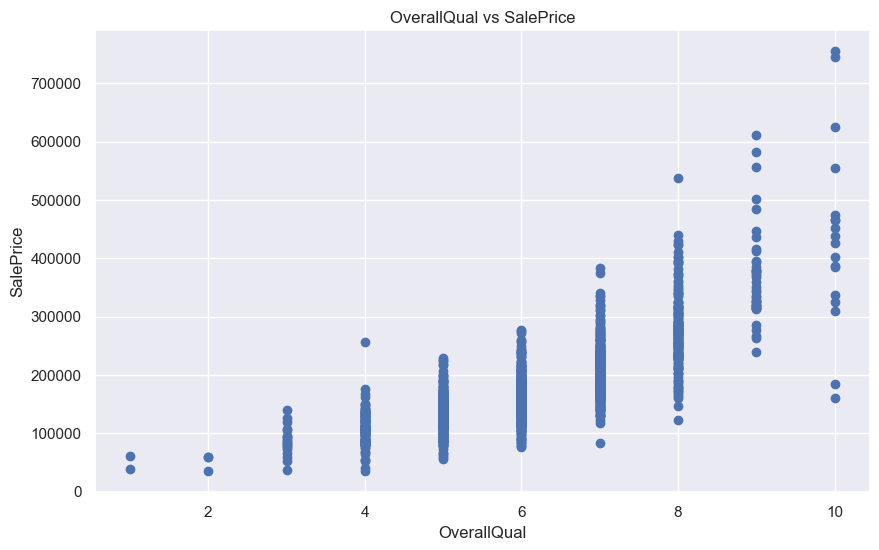

In [13]:
# Display basic statistics of the target variable
print(train_data['SalePrice'].describe())

# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(train_data['SalePrice'], kde=True)
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

# Correlation matrix of numeric features
numeric_features = train_data.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = train_data[numeric_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# Top 10 features correlated with SalePrice
top_corr_features = correlation_matrix['SalePrice'].abs().sort_values(ascending=False).head(11)
print("Top 10 features correlated with SalePrice:")
print(top_corr_features[1:])  # Exclude SalePrice itself

# Scatter plot of the most correlated feature with SalePrice
top_feature = top_corr_features.index[1]
plt.figure(figsize=(10, 6))
plt.scatter(train_data[top_feature], train_data['SalePrice'])
plt.title(f'{top_feature} vs SalePrice')
plt.xlabel(top_feature)
plt.ylabel('SalePrice')
plt.show()

In [14]:
# Separate features and target
X = train_data.drop('SalePrice', axis=1)
y = train_data['SalePrice']

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print("Number of numeric features:", len(numeric_features))
print("Number of categorical features:", len(categorical_features))

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit the preprocessor to the training data and transform
X_processed = preprocessor.fit_transform(X)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

print("Preprocessing complete. Ready for model training.")

Number of numeric features: 37
Number of categorical features: 43
Preprocessing complete. Ready for model training.


In [15]:
def train_and_evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    train_mse = mean_squared_error(y_train, train_pred)
    val_mse = mean_squared_error(y_val, val_pred)
    train_r2 = r2_score(y_train, train_pred)
    val_r2 = r2_score(y_val, val_pred)
    
    print(f"{model_name} Results:")
    print(f"Train MSE: {train_mse:.2f}")
    print(f"Validation MSE: {val_mse:.2f}")
    print(f"Train R2: {train_r2:.2f}")
    print(f"Validation R2: {val_r2:.2f}")
    print()
    
    return model, train_r2, val_r2

# Linear Regression
lr_model, lr_train_r2, lr_val_r2 = train_and_evaluate_model(
    LinearRegression(), X_train, X_val, y_train, y_val, "Linear Regression")

# Random Forest
rf_model, rf_train_r2, rf_val_r2 = train_and_evaluate_model(
    RandomForestRegressor(n_estimators=100, random_state=42), X_train, X_val, y_train, y_val, "Random Forest")

# XGBoost
xgb_model, xgb_train_r2, xgb_val_r2 = train_and_evaluate_model(
    xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42), X_train, X_val, y_train, y_val, "XGBoost")

Linear Regression Results:
Train MSE: 357354639.40
Validation MSE: 4269799606.06
Train R2: 0.94
Validation R2: 0.44

Random Forest Results:
Train MSE: 121189750.52
Validation MSE: 833648030.57
Train R2: 0.98
Validation R2: 0.89

XGBoost Results:
Train MSE: 28541872.82
Validation MSE: 652398223.48
Train R2: 1.00
Validation R2: 0.91



This will set the style for plots to 'seaborn-whitegrid', which is a valid style name.

Would you like me to provide the corrected code?

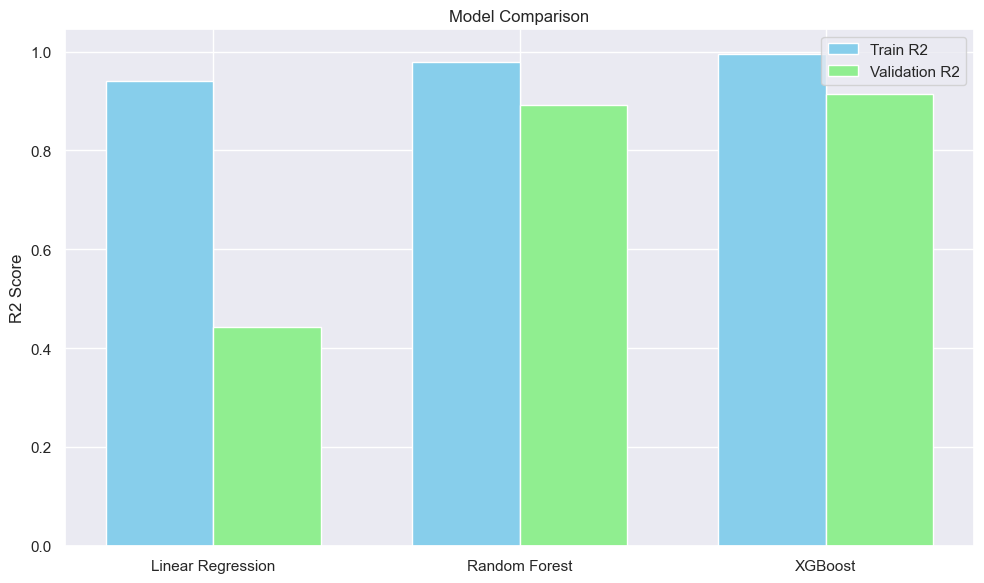

Model Comparison:
Linear Regression: Train R2 = 0.9401, Validation R2 = 0.4433
Random Forest: Train R2 = 0.9797, Validation R2 = 0.8913
XGBoost: Train R2 = 0.9952, Validation R2 = 0.9149


In [17]:
models = ['Linear Regression', 'Random Forest', 'XGBoost']
train_r2_scores = [lr_train_r2, rf_train_r2, xgb_train_r2]
val_r2_scores = [lr_val_r2, rf_val_r2, xgb_val_r2]

plt.figure(figsize=(10, 6))
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, train_r2_scores, width, label='Train R2', color='skyblue')
plt.bar(x + width/2, val_r2_scores, width, label='Validation R2', color='lightgreen')

plt.ylabel('R2 Score')
plt.title('Model Comparison')
plt.xticks(x, models)
plt.legend()

plt.tight_layout()
plt.show()

print("Model Comparison:")
for model, train, val in zip(models, train_r2_scores, val_r2_scores):
    print(f"{model}: Train R2 = {train:.4f}, Validation R2 = {val:.4f}")